<a href="https://colab.research.google.com/github/dewnavapan/Csharp/blob/master/ScanbankModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-02-16 05:09:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-16 05:09:33 (59.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
dataset = "/content/drive/MyDrive/Datasets"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/drive/MyDrive/Datasets'.
There are 9 directories and 0 images in '/content/drive/MyDrive/Datasets/test'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/500'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/1000'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/100'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/50'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/20'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/5'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/10'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/1'.
There are 0 directories and 10 images in '/content/drive/MyDrive/Datasets/test/2'.
There are 9 directories and 0 images in '/content/drive/MyDrive/Datasets/train'.
There a

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
len(list(image_dir.glob(r'**/*.jpg')))

2803

In [ ]:
image_df

Filepath Label
0     /content/drive/MyDrive/Datasets/train/1/1 Bath...     1
1     /content/drive/MyDrive/Datasets/train/1/1 Bath...     1
2     /content/drive/MyDrive/Datasets/train/1/1 Bath...     1
3     /content/drive/MyDrive/Datasets/test/500/20231...   500
4     /content/drive/MyDrive/Datasets/test/500/20231...   500
...                                                 ...   ...
2802  /content/drive/MyDrive/Datasets/train/100/THAI...   100
2803  /content/drive/MyDrive/Datasets/train/100/THAI...   100
2804  /content/drive/MyDrive/Datasets/train/100/THAI...   100
2805  /content/drive/MyDrive/Datasets/train/100/THAI...   100
2806  /content/drive/MyDrive/Datasets/train/1000/d20...  1000

[2807 rows x 2 columns]

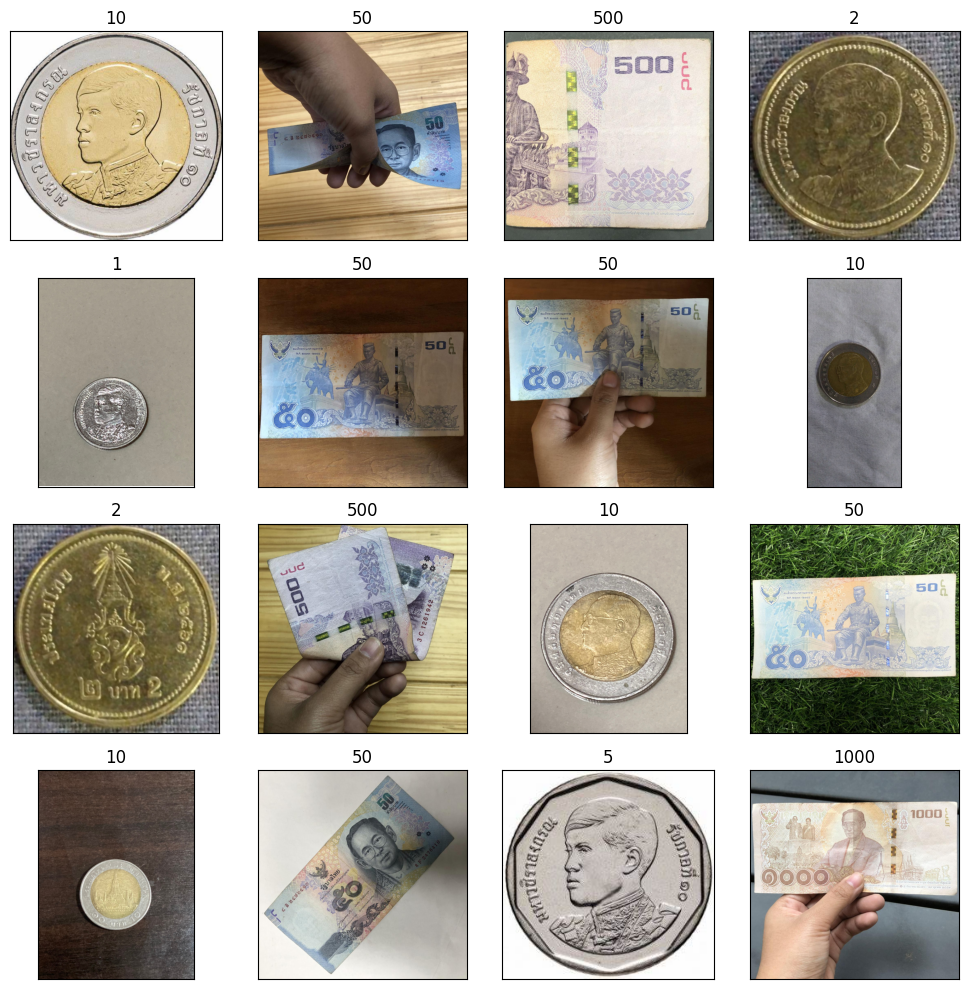

In [ ]:
import matplotlib.image as mpimg
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(image_df.Filepath[random_index[i]])
    ax.imshow(image)
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.1
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=36,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2274 validated image filenames belonging to 9 classes.
Found 252 validated image filenames belonging to 9 classes.
Found 281 validated image filenames belonging to 9 classes.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 8,
                               restore_best_weights = True)

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(9, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "fire_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/fire_classification/20240216-051118
Epoch 1/100
64/64 [==============================] - 933s 14s/step - loss: 1.7346 - accuracy: 0.3588 - val_loss: 1.1408 - val_accuracy: 0.6190
Epoch 2/100
64/64 [==============================] - 150s 2s/step - loss: 1.1125 - accuracy: 0.5800 - val_loss: 0.8338 - val_accuracy: 0.7421
Epoch 3/100
64/64 [==============================] - 151s 2s/step - loss: 0.8764 - accuracy: 0.6799 - val_loss: 0.6647 - val_accuracy: 0.8175
Epoch 4/100
64/64 [==============================] - 146s 2s/step - loss: 0.7072 - accuracy: 0.7559 - val_loss: 0.5302 - val_accuracy: 0.8730
Epoch 5/100
64/64 [==============================] - 163s 3s/step - loss: 0.5507 - accuracy: 0.8267 - val_loss: 0.4163 - val_accuracy: 0.8968
Epoch 6/100
64/64 [==============================] - 146s 2s/step - loss: 0.4599 - accuracy: 0.8588 - val_loss: 0.3499 - val_accuracy: 0.9206
Epoch 7/100
64/64 [==============================] - 148s 2s/ste

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.01749
Test Accuracy: 99.64%


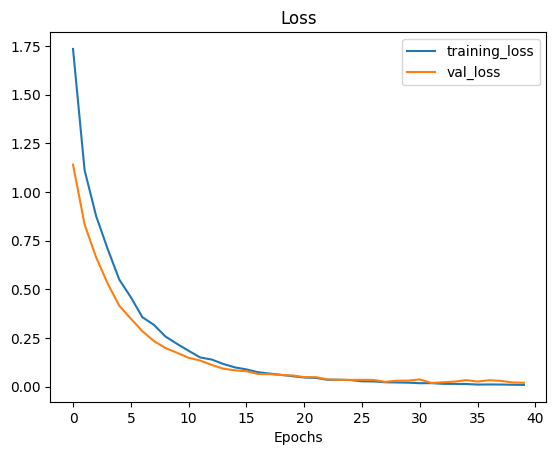

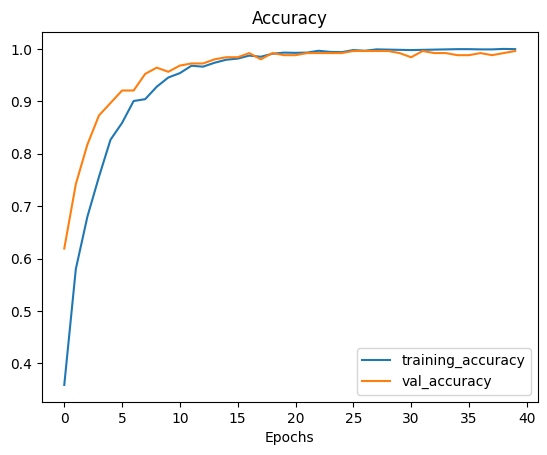

In [ ]:
plot_loss_curves(history)

In [ ]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

9/9 [==============================] - 24s 3s/step
The first 5 predictions: ['10', '100', '20', '100', '50']


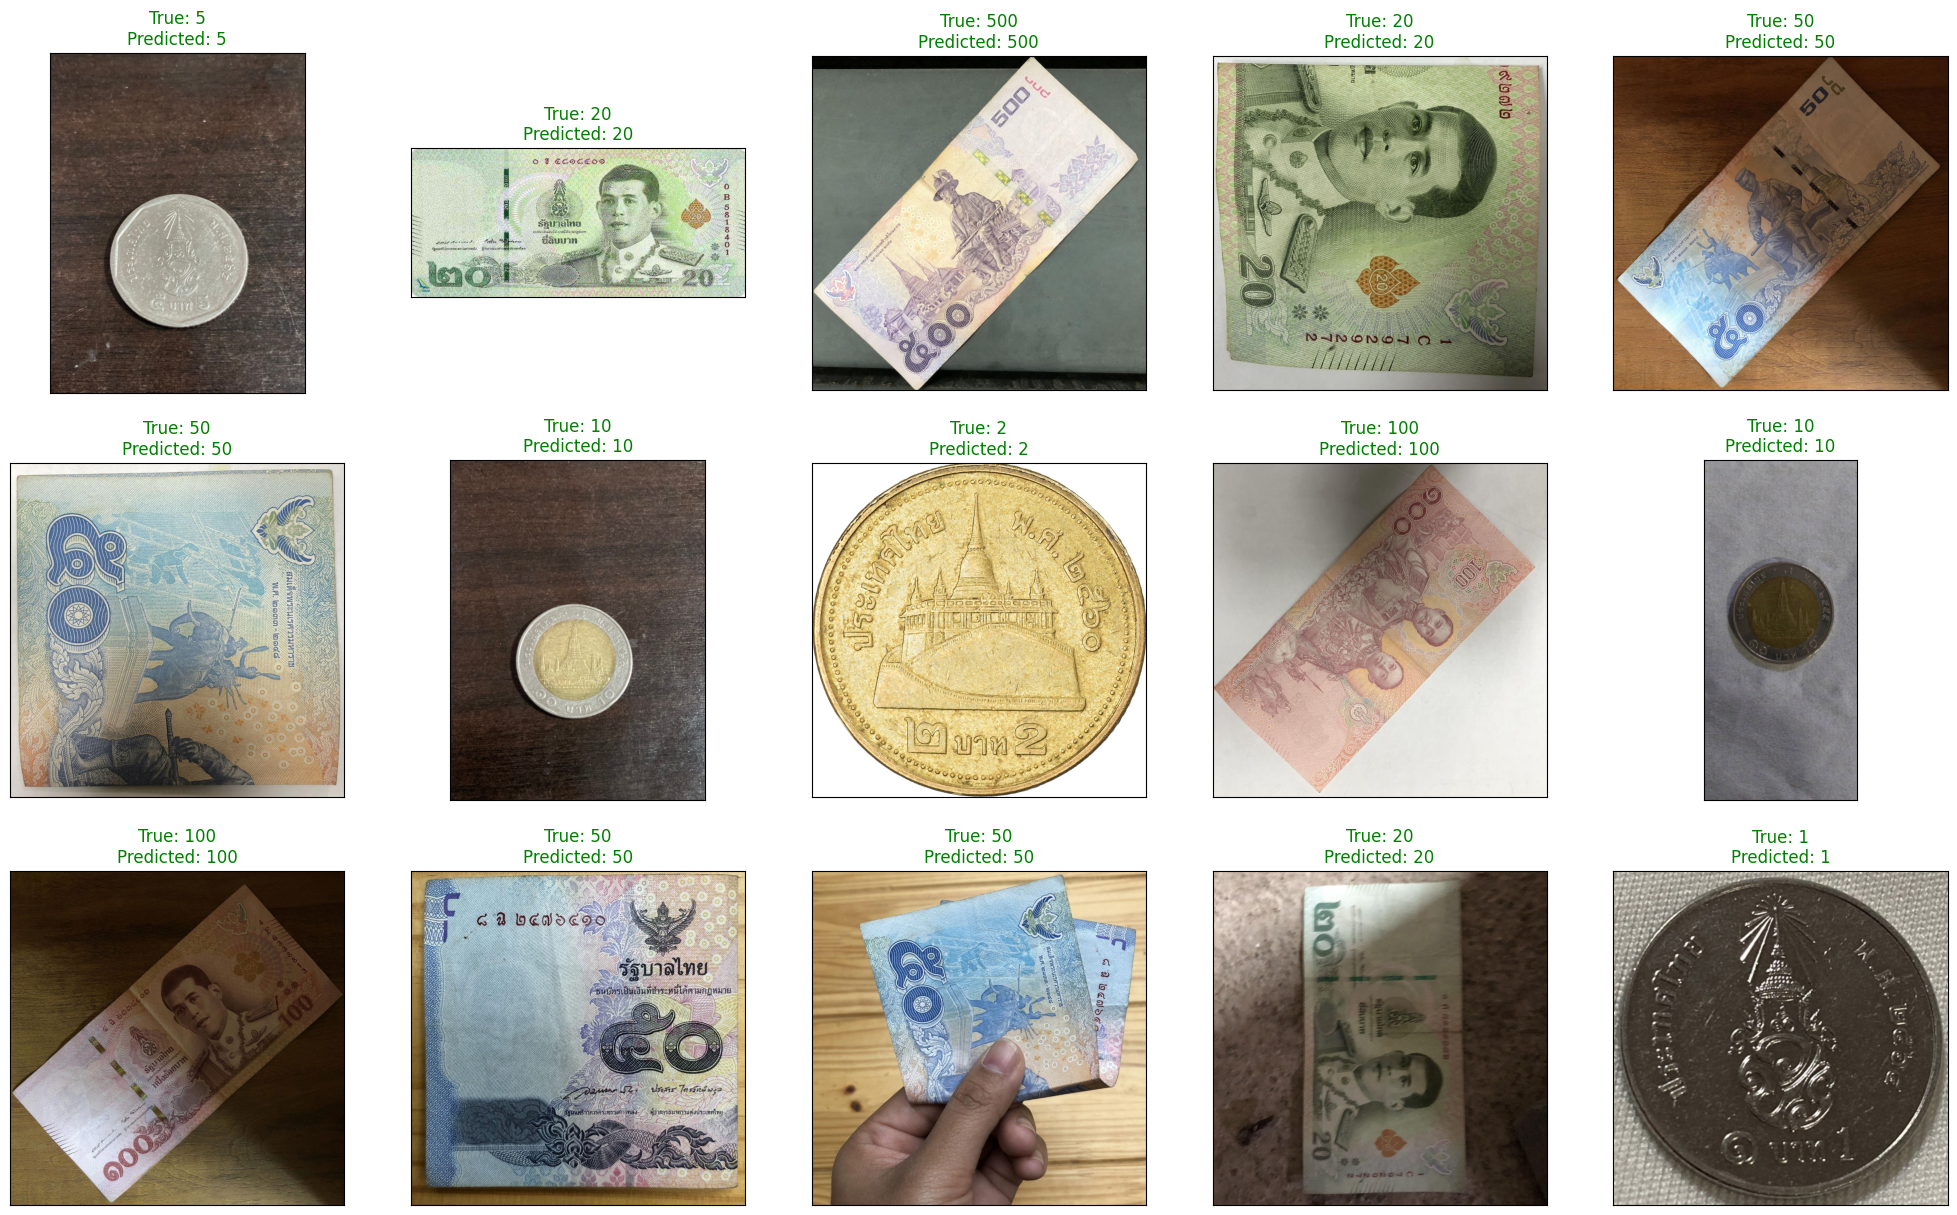

<Figure size 640x480 with 0 Axes>

In [ ]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        36
          10       1.00      1.00      1.00        48
         100       0.97      1.00      0.98        30
        1000       1.00      0.96      0.98        26
           2       1.00      1.00      1.00        26
          20       1.00      1.00      1.00        44
           5       1.00      1.00      1.00        21
          50       1.00      1.00      1.00        26
         500       1.00      1.00      1.00        24

    accuracy                           1.00       281
   macro avg       1.00      1.00      1.00       281
weighted avg       1.00      1.00      1.00       281



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score     support
1              1.000000  1.000000  1.000000   36.000000
10             1.000000  1.000000  1.000000   48.000000
100            0.967742  1.000000  0.983607   30.000000
1000           1.000000  0.961538  0.980392   26.000000
2              1.000000  1.000000  1.000000   26.000000
20             1.000000  1.000000  1.000000   44.000000
5              1.000000  1.000000  1.000000   21.000000
50             1.000000  1.000000  1.000000   26.000000
500            1.000000  1.000000  1.000000   24.000000
accuracy       0.996441  0.996441  0.996441    0.996441
macro avg      0.996416  0.995726  0.996000  281.000000
weighted avg   0.996556  0.996441  0.996436  281.000000

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

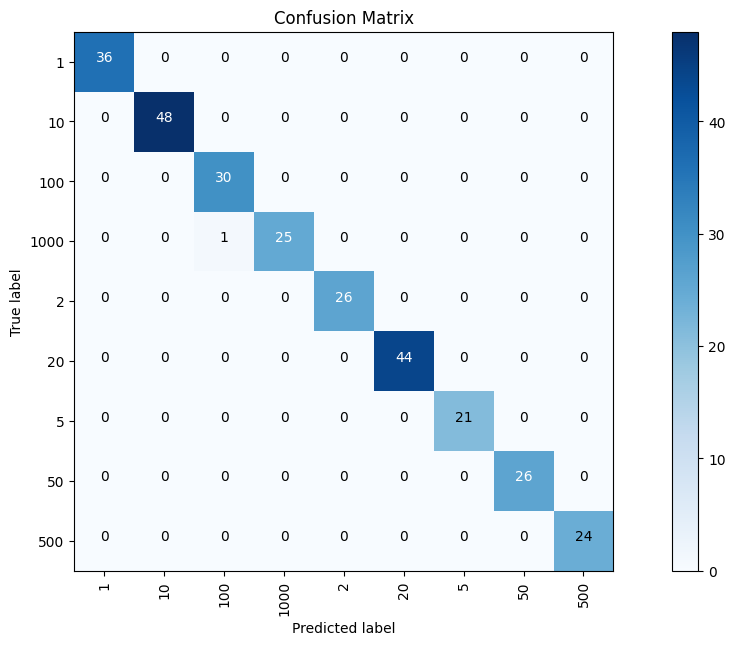

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

In [ ]:
model.save('model8.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

# โมเดล Keras ที่คุณต้องการแปลง
keras_model_path = 'model8.h5'

# โปรแกรมจะใช้โมเดลที่ถูกฝึกด้วย Keras
keras_model = tf.keras.models.load_model(keras_model_path)

# กำหนดชื่อไฟล์ที่จะบันทึกโมเดล TensorFlow Lite
tflite_model_path = '/content/drive/MyDrive/model8.tflite'

# ใช้ TensorFlow Lite Converter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

# ให้ TensorFlow Lite Converter ใช้ค่าแม่นยำของโมเดลเดิมโดยไม่สูญเสีย
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

# แปลงเป็น TensorFlow Lite model
tflite_model = converter.convert()

# บันทึกโมเดล TensorFlow Lite
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


In [ ]:
# ดึง label จาก class_indices ที่ได้จาก train_images
class_indices = train_images.class_indices

# สลับคีย์และค่าใน class_indices เพื่อให้เป็น mapping จากตัวเลขไปยังชื่อคลาส
label_mapping = {v: k for k, v in class_indices.items()}

# แสดง mapping
print(label_mapping)


{0: '1', 1: '10', 2: '100', 3: '1000', 4: '2', 5: '20', 6: '5', 7: '50', 8: '500'}


In [ ]:
# ตัวอย่างการดึง label จาก validation data
for batch in val_images:
    images, labels = batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # แสดงตัวอย่าง label ที่ถูกทำนาย
    for i in range(len(predicted_labels)):
        print(f"Predicted label: {label_mapping[predicted_labels[i]]}, True label: {label_mapping[true_labels[i]]}")


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
Predicted label: 5, True label: 5
Predicted label: 500, True label: 500
Predicted label: 5, True label: 5
Predicted label: 500, True label: 500
Predicted label: 1000, True label: 1000
Predicted label: 50, True label: 50
Predicted label: 1000, True label: 1000
Predicted label: 100, True label: 100
Predicted label: 500, True label: 500
Predicted label: 1, True label: 1
Predicted label: 2, True label: 2
Predicted label: 50, True label: 50
Predicted label: 2, True label: 2
Predicted label: 10, True label: 10
Predicted label: 1000, True label: 1000
Predicted label: 100, True label: 100
Predicted label: 50, True label: 50
Predicted label: 20, True label: 20
Predicted label: 2, True label: 2
Predicted label: 5, True label: 5
Predicted label: 1000, True label: 1000
Predicted label: 500, True label: 500
Predicted label: 100, True label: 100
Predicted label: 10, True label: 10
Predicted label: 2, True label: 2
Predicted label: 20, True lab

KeyboardInterrupt: 

In [ ]:
# สร้างไฟล์ข้อความเพื่อบันทึก mapping
txt_file_path = 'label8.txt'

with open(txt_file_path, mode='w') as file:
    for class_index, class_name in label_mapping.items():
        file.write(f"Class_Index: {class_index}, Class_Name: {class_name}\n")

print(f"Label mapping has been saved to {txt_file_path}")


Label mapping has been saved to label8.txt
